## **Context**

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
#Read data
data = pd.read_csv('spam.csv', encoding='ISO-8859-1', usecols=['v1', 'v2'])
data.rename(columns={'v1':'labels', 'v2':'content'}, inplace=True)

print("data shape: ", data.shape)
display(data.head())

data shape:  (5572, 2)


,labels,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### EDA

ham     0.865937
spam    0.134063
Name: labels, dtype: float64

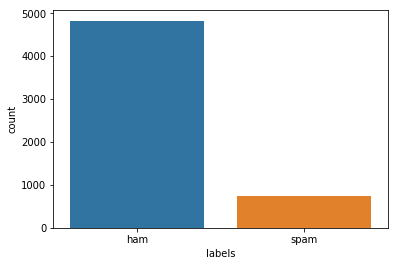

In [3]:
#distribution of the labels to check for imbalance
sns.countplot(data.labels);
data['labels'].value_counts(normalize=True)

We have an imbalanced dataset.

In [4]:
#Example for a ham content
ham_indices = data[data.labels == 'ham'].index
random_ham = np.random.choice(ham_indices)

data.iloc[random_ham, :].content

'Yes i will be there. Glad you made it.'

In [5]:
#Example for a spam content
spam_indices = data[data.labels == 'spam'].index
random_ham = np.random.choice(spam_indices)

data.iloc[random_ham, :].content

'Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!'

**wordcloud plots**

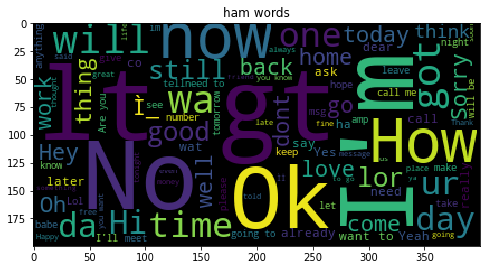

In [6]:
f = plt.figure(figsize=(8,12))
wordcloud = WordCloud(max_words=100).\
            generate(' '.join(data.loc[data['labels'] == 'ham', 'content'].to_list()))
plt.imshow(wordcloud)
plt.title('ham words');

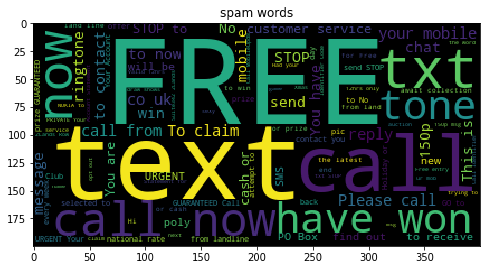

In [7]:
f = plt.figure(figsize=(8,12))
wordcloud = WordCloud(max_words=100).\
            generate(' '.join(data.loc[data['labels'] == 'spam', 'content'].to_list()))
plt.imshow(wordcloud)
plt.title('spam words');

**top 30 words for spam**

In [8]:
from collections import Counter

spam_text = ' '.join(data.iloc[spam_indices]['content'])
spam_list = spam_text.lower().split()

cnt = Counter()

for word in spam_list:
    if word not in stopwords.words('english'):
        cnt[word] += 1
        
cnt.most_common(30)

[('call', 342),
 ('free', 180),
 ('2', 169),
 ('ur', 144),
 ('txt', 136),
 ('u', 117),
 ('text', 112),
 ('mobile', 109),
 ('claim', 106),
 ('reply', 101),
 ('&', 98),
 ('4', 93),
 ('stop', 89),
 ('get', 82),
 ('now!', 70),
 ('new', 69),
 ('send', 65),
 ('nokia', 64),
 ('win', 58),
 ('prize', 58),
 ('cash', 56),
 ('contact', 56),
 ('-', 55),
 ('please', 52),
 ('service', 48),
 ('per', 44),
 ('urgent!', 42),
 ('customer', 40),
 ('tone', 40),
 ('chat', 39)]

**Top 30 words for ham**

In [9]:
ham_text = ' '.join(data.iloc[ham_indices]['content'])
ham_list = ham_text.lower().split()

cnt = Counter()

for word in ham_list:
    if word not in stopwords.words('english'):
        cnt[word] += 1
        
cnt.most_common(30)

[('u', 874),
 ("i'm", 369),
 ('get', 293),
 ('2', 284),
 ('&lt;#&gt;', 276),
 ('go', 235),
 ('ur', 235),
 ('got', 227),
 ('.', 222),
 ('like', 221),
 ('call', 215),
 ('come', 215),
 ('know', 208),
 ('good', 187),
 ('?', 181),
 ("i'll", 167),
 ('...', 162),
 ('going', 157),
 ('ok', 156),
 ('4', 156),
 ('want', 153),
 ('time', 153),
 ('love', 149),
 ('need', 147),
 ('still', 144),
 ('one', 141),
 ('n', 134),
 ('r', 131),
 ('see', 126),
 ('think', 124)]

### Preprocessing

Removing too small sentences or too large ones

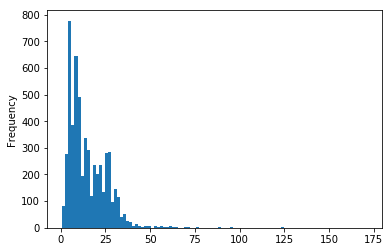

In [10]:
word_count = data['content'].apply(lambda s: len(s.split()))
word_count.plot.hist(bins=100);

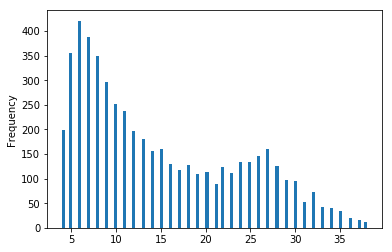

In [11]:
word_count[(word_count < word_count.quantile(0.98)) & (word_count > word_count.quantile(0.02))].plot.hist(bins=100);

In [12]:
data = data[(word_count < word_count.quantile(0.98)) & (word_count > word_count.quantile(0.02))]

In [13]:
print(data.shape)

(5290, 2)


Removed a bit over 200 sentences

**TFIDF**

A method that will help us convert text data to numerical data. This method assigns weights for each document term, taking into consideration the frequency of a term in a document and the frequency of a term across all documents.

In [14]:
cv = TfidfVectorizer(max_features=5000, stop_words='english')
sparse_mat = cv.fit_transform(data['content'])

In [15]:
X = sparse_mat.toarray()
print(X.shape)

(5290, 5000)


In [16]:
#print some of the features
print(cv.get_feature_names()[1000:1005])

['certainly', 'cha', 'challenge', 'chance', 'chances']


**splitting data**

In [17]:
#split data
from sklearn.model_selection import train_test_split
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Validation

In [18]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(4232, 5000)
(4232,)
(1058,)
(1058, 5000)


### Boosting

A procedure that combines the outputs of many "weak classifiers(or tree stumps) to produce a powerful committee. 

In [19]:
#fitting the model
ada_model = AdaBoostClassifier( n_estimators=100)
ada_model.fit(X_train, y_train)

ada_preds = ada_model.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#printing metrics
print("Accuracy score: ", accuracy_score(y_test, ada_preds))
print("Confusion matrix: \n",confusion_matrix(y_test, ada_preds))
print("Classification report: \n",classification_report(y_test, ada_preds))

Accuracy score:  0.9735349716446124
Confusion matrix: 
 [[908   1]
 [ 27 122]]
Classification report: 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       909
        spam       0.99      0.82      0.90       149

    accuracy                           0.97      1058
   macro avg       0.98      0.91      0.94      1058
weighted avg       0.97      0.97      0.97      1058



**top 10 important word/features in our Adaboost model**

In [21]:
feat_importance_index = np.argsort(ada_model.feature_importances_)[-10:]

print("10 top important words: \n", pd.Series(cv.get_feature_names())[feat_importance_index])

10 top important words: 
 1093        com
2353    message
248         100
1152       cost
410          50
3219      reply
2509        new
4188       text
2400     mobile
3420       send
dtype: object


**Plotting top 3 tree stumps(weak classifiers)**

In [22]:
top_3 = np.argsort(ada_model.estimator_weights_)[-3:]

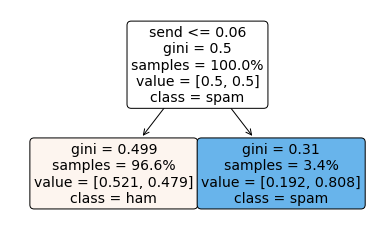

In [23]:
plot_tree(ada_model.estimators_[top_3[0]], class_names=['ham', 'spam'], proportion=True,
               rounded=True, filled=True, feature_names=cv.get_feature_names());

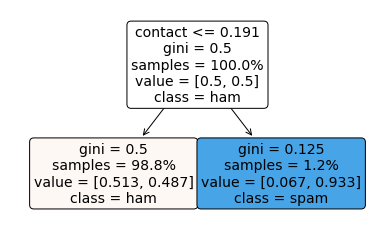

In [24]:
plot_tree(ada_model.estimators_[top_3[1]], class_names=['ham', 'spam'], proportion=True,
               rounded=True, filled=True, feature_names=cv.get_feature_names());

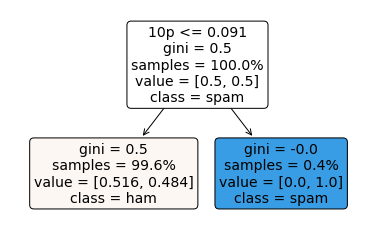

In [25]:
plot_tree(ada_model.estimators_[top_3[2]], class_names=['ham', 'spam'], proportion=True,
               rounded=True, filled=True, feature_names=cv.get_feature_names());

### Bagging

In [26]:
#Fitting the model
model_rf = RandomForestClassifier(n_estimators=100)
model_rf = model_rf.fit(X_train, y_train)
#Predicting
y_rf_pred = model_rf.predict(X_test)

In [27]:
#print metrics
print('accuracy_score: ', accuracy_score(y_test, y_rf_pred))
print('confusion matrix: \n', confusion_matrix(y_test, y_rf_pred))
print('report: \n', classification_report(y_test, y_rf_pred))

accuracy_score:  0.9773156899810964
confusion matrix: 
 [[908   1]
 [ 23 126]]
report: 
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       909
        spam       0.99      0.85      0.91       149

    accuracy                           0.98      1058
   macro avg       0.98      0.92      0.95      1058
weighted avg       0.98      0.98      0.98      1058



**top 10 important word/features in our Random Forest model**

In [28]:
feat_importance_index = np.argsort(model_rf.feature_importances_)[-10:]

print("10 top important words: \n", pd.Series(cv.get_feature_names())[feat_importance_index])

10 top important words: 
 4188      text
410         50
291       150p
3887      stop
4412        uk
2400    mobile
4878       www
1616      free
1053     claim
4391       txt
dtype: object


**Plotting the first decision tree in the RF model.**

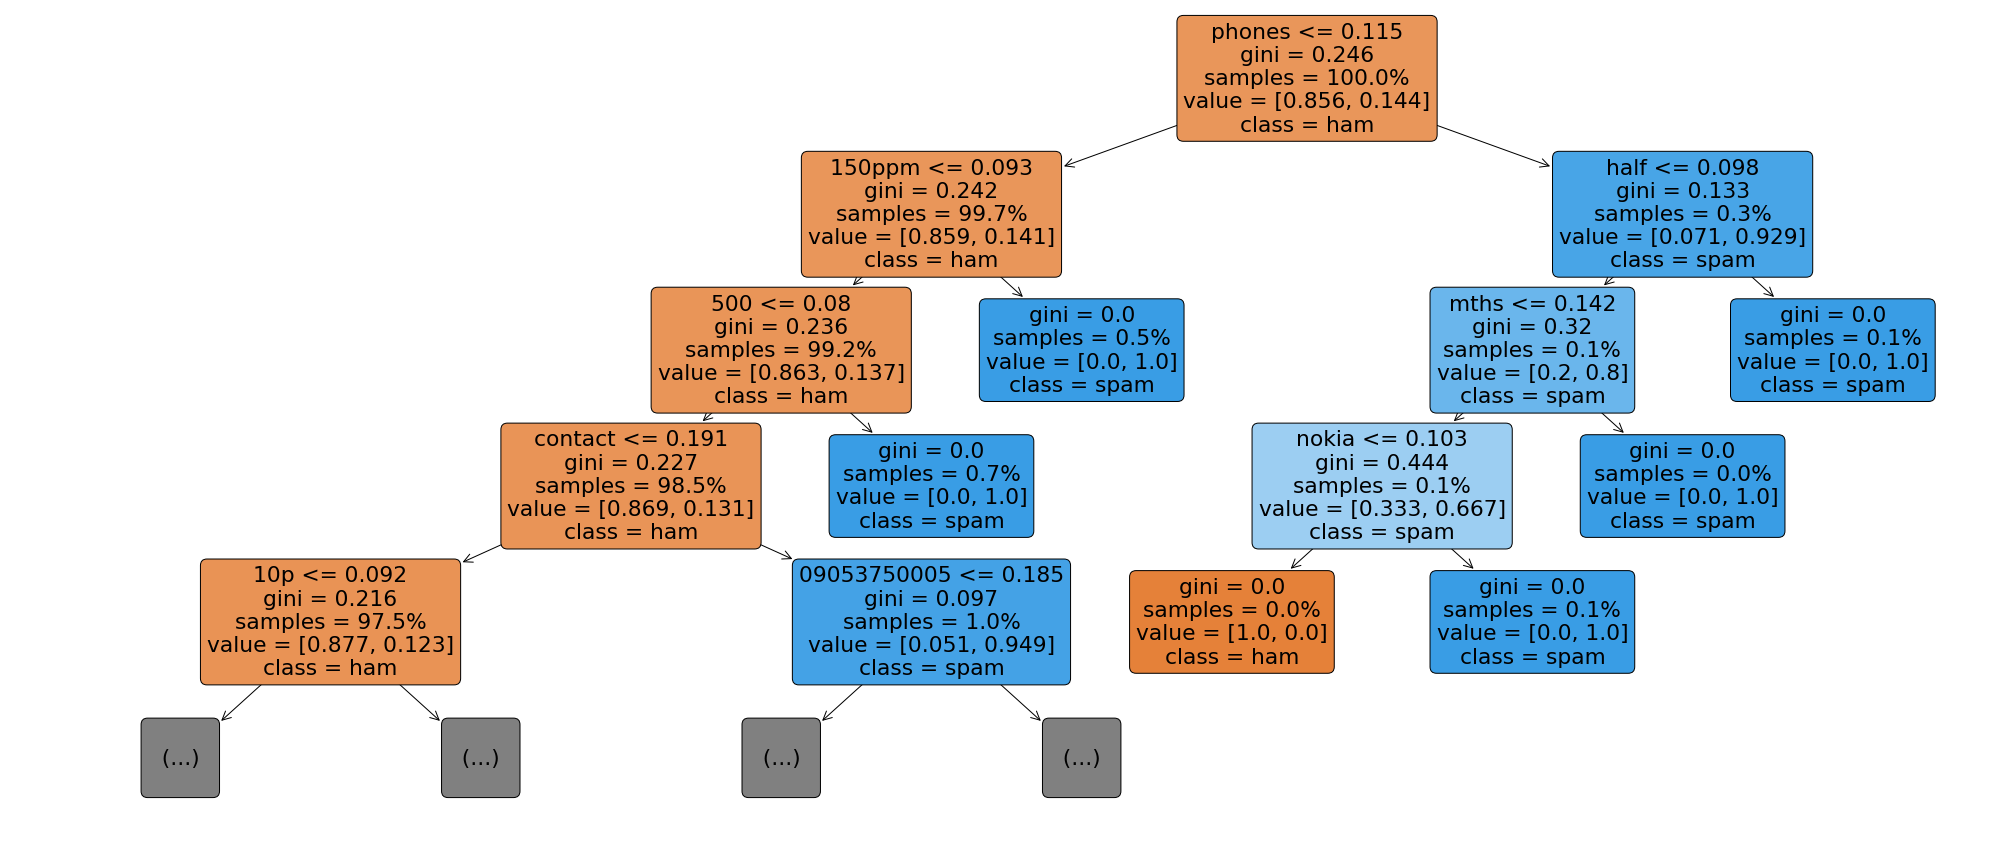

In [29]:
f = plt.figure(figsize=(35,15))
plot_tree(model_rf.estimators_[0], class_names=['ham', 'spam'], proportion=True,
               rounded=True, filled=True, max_depth=4, 
               feature_names=cv.get_feature_names());

### Pipelines

The advanced way

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data['content'], 
                                                    data['labels'], 
                                                    stratify=data['labels'])

In [31]:
from sklearn.pipeline import Pipeline

Adaboost

In [32]:
pipeline = Pipeline(steps=[
                           ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
                           ('model', AdaBoostClassifier(n_estimators=100))])
_ = pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1137
        spam       0.96      0.84      0.90       186

    accuracy                           0.97      1323
   macro avg       0.97      0.92      0.94      1323
weighted avg       0.97      0.97      0.97      1323



Random Forest

In [33]:
pipeline = Pipeline(steps=[
                           ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
                           ('model', RandomForestClassifier(n_estimators=100))])
_ = pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1137
        spam       1.00      0.83      0.91       186

    accuracy                           0.98      1323
   macro avg       0.99      0.91      0.95      1323
weighted avg       0.98      0.98      0.97      1323



**I will only continue with Random Forest.** 

1) I will to use TruncatedSVD to reduce the dimensions. TSVD is good for sparse data whereas PCA is good for dense data.

2) I will try oversampling methods since our data is imbalanced. These methods may improve the f1-score and the recall. I will use SMOTE and RandomOverSampler

Part 1 - 

In [34]:
from sklearn.decomposition import TruncatedSVD

pipeline = Pipeline(steps=[
                           ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
                           ('dim_reduction', TruncatedSVD(n_components=100)),
                           ('model', RandomForestClassifier(n_estimators=100))])
_ = pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         ham       0.97      0.99      0.98      1137
        spam       0.96      0.80      0.87       186

    accuracy                           0.97      1323
   macro avg       0.96      0.90      0.93      1323
weighted avg       0.97      0.97      0.97      1323



Part 2- 

over-sampling is simply a process of repeating some samples of the minority class and balance the number of samples between classes in the dataset.

In [35]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

In [43]:
pipeline = make_pipeline(
                           TfidfVectorizer(max_features=5000, stop_words='english'),
                           RandomOverSampler(),
                           RandomForestClassifier(n_estimators=100))

_ = pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1137
        spam       0.99      0.87      0.93       186

    accuracy                           0.98      1323
   macro avg       0.99      0.94      0.96      1323
weighted avg       0.98      0.98      0.98      1323

[[1136    1]
 [  24  162]]


We can see that we improved the recall for our minority class(spam) and the f1-score.

**accruacy score is not the right metric when we have imbalance in the data**